In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# import tensorflow as tf
import functools
import jax.numpy as jnp
import os
import json_lines
import numpy as np
import json

import jax
from jax.experimental import optimizers
from src import data, model_utils, optim_utils, measurements
from renn.rnn import cells, unroll, network
from renn import utils
import renn

from data_processing import analysis_utils as au
from renn import analysis_utils as renn_au

import tensorflow_datasets as tfds

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

## Performances vs. L2 and learning rate

In [3]:
LEARNING_RATES = [0.01]
L2_PENALTIES = [0.001, 0.001389495, 0.001930698, 0.002682696, 0.003727594, 0.005179475, 0.007196857, 0.01, 
                0.01389495, 0.01930698, 0.02682696, 0.03727594, 0.05179475, 0.07196857, 0.1, 0.13894955, 
                0.19306977, 0.26826958, 0.37275937, 0.51794747, 0.71968567, 1.0]

results = {}
shuffled_results = {}

In [4]:
def parse_folder(f):
    s = f.split('_')
    arch = s[0]
    eta = s[2]
    L2 = s[4]
    return arch, eta, L2

In [5]:
def extract(f, metric='test_acc'):
    with open(os.path.join(f, f'{metric}.jsonl')) as fi:
        x = json_lines.reader(fi)
        return list(x)[-1]['value']

In [6]:
base_folder = 'results/yelp/five_class_fine_L2/'

folders = os.listdir(base_folder)
for folder in folders:
    arch, eta, L2 = parse_folder(folder)
    acc = extract(os.path.join(base_folder, folder), 'test_acc')
    shuffled_acc = extract(os.path.join(base_folder, folder), 'shuffled_test_acc')
    results[(arch, float(eta), float(L2))] = acc
    shuffled_results[(arch, float(eta), float(L2))] = shuffled_acc

In [7]:
def group(full_results, arch):
    ret = np.array([[full_results[(arch, lr, l2)] for l2 in L2_PENALTIES] for lr in LEARNING_RATES])
    return ret

In [9]:
arch = 'LSTM'
xx = group(results, arch)
xx_shuffled = group(shuffled_results, arch)

Text(0.5, 1.0, 'LSTM')

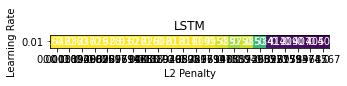

In [10]:
f, ax = plt.subplots(figsize=(5,10))
im = ax.imshow(xx, cmap='viridis', vmin=0.4, vmax=0.6)

ax.set_yticks(np.arange(len(LEARNING_RATES)))
ax.set_yticklabels(LEARNING_RATES)
ax.set_ylabel('Learning Rate')

ax.set_xticks(np.arange(len(L2_PENALTIES)))
ax.set_xticklabels(L2_PENALTIES)
ax.set_xlabel('L2 Penalty')

for (j,i),label in np.ndenumerate(xx):
    ax.text(i,j,np.round(label,3),ha='center',va='center', color='white')
    
ax.set_title(f'{arch}')

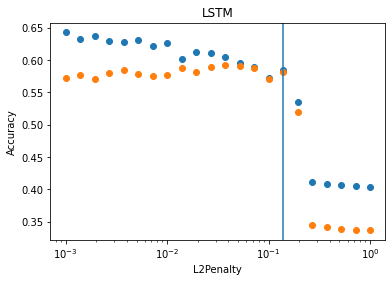

In [120]:
plt.scatter(L2_PENALTIES, xx[0])
plt.scatter(L2_PENALTIES, xx_shuffled[0])
plt.semilogx()
plt.xlabel("L2Penalty")
plt.ylabel('Accuracy')
plt.title(arch)

lin_num = 15
plt.axvline(L2_PENALTIES[lin_num])

## Model and data loading

In [121]:
L2_PENALTIES[lin_num]

0.13894955

In [122]:
data_folder = 'results/yelp/five_class_fine_L2/LSTM_eta_0.01_L2_0.13894955_run_jwa9qq5l/'

In [123]:
with open(os.path.join(data_folder, 'config.json')) as f:
    config = json.load(f)

In [124]:
with open(os.path.join(data_folder, 'test_acc.jsonl')) as f:
    x = f.readlines()
x[-1]

'{"step": 5056, "value": 0.5848734430971755}\n'

### Data loading

In [125]:
vocab_size, train_dset, test_dset = data.get_dataset(config['data'])
print("Data config\n")
print(config['data'])

Data config

{'dataset': 'yelp', 'batch_size': 256, 'max_pad': 800, 'num_classes': 5}


### Model loading

In [126]:
cell = model_utils.get_cell(config['model']['cell_type'],
                            num_units=config['model']['num_units'])

In [127]:
init_fun, apply_fun, emb_apply, readout_apply = network.build_rnn(vocab_size,
                                                                  config['model']['emb_size'],
                                                                  cell,
                                                                  num_outputs=config['model']['num_outputs'])
emb_init, emb_apply = renn.embedding(vocab_size, 
                                     config['model']['emb_size'])

In [128]:
network_params = model_utils.load_params(os.path.join(data_folder, 'final_params'))
emb_params, rnn_params, readout_params = network_params

#### Checksums

We check if the accuracy and the L2 norm of the parameters match what we expect from the data (json) files.

In [129]:
optimizers.l2_norm(rnn_params)

DeviceArray(1.4762021, dtype=float32)

## Analysis

### PCA

In [130]:
transform_to_use = 'final'

In [131]:
test_batch = next(iter(tfds.as_numpy(test_dset)))

In [132]:
visited_states = {'original': au.rnn_states(cell, test_batch, rnn_params, emb_params, emb_apply)}
final_states = {'original': au.rnn_end_states(cell, test_batch, rnn_params, emb_params, emb_apply)}

In [133]:
PCA_objects = {'visited': au.PCA_rnn(),
               'final': au.PCA_rnn(),
               'fixed': au.PCA_rnn()}

PCA_objects['visited'].fit(np.vstack(visited_states['original']))
PCA_objects['final'].fit(np.vstack(final_states['original']))

PCA_rnn()

In [134]:
len(final_states['original'])

256

In [135]:
visited_states['transformed'] = [PCA_objects[transform_to_use].transform(v) for v in visited_states['original']]
final_states['transformed'] = [PCA_objects[transform_to_use].transform(f) for f in final_states['original']]

In [136]:
dimensionalities = {'visited': au.cumulative_var_explained(PCA_objects['visited']),
                    'final': au.cumulative_var_explained(PCA_objects['final'])}

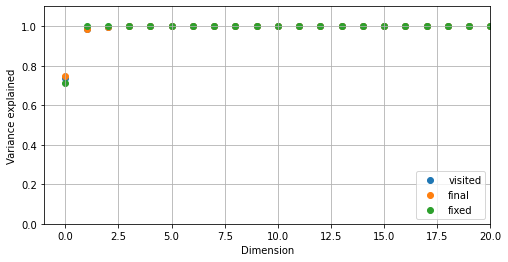

In [293]:
f = au.plot_varexp(dimensionalities)

In [288]:
coordinates = ['original', 'transformed']

num_to_view = -1

visited_by_value = {c: au.states_by_value(visited_states[c][:num_to_view], test_batch['labels'][:num_to_view], config['data']['num_classes']) for c in coordinates}
final_by_value = {c: au.states_by_value(final_states[c][:num_to_view], test_batch['labels'][:num_to_view], config['data']['num_classes']) for c in coordinates}

### Trajectory visualization

In [289]:
initial_state_vector = {'original': cell.get_initial_state(rnn_params, batch_size=1)}
initial_state_vector['transformed'] = PCA_objects[transform_to_use].transform(initial_state_vector['original'])

In [290]:
readout_vectors = {'original': readout_params[0].T}
readout_vectors['transformed'] = PCA_objects[transform_to_use].transform_no_mean(readout_vectors['original'])

(-2.062276780605316,
 2.476123034954071,
 -2.2022228121757506,
 2.3361770033836367)

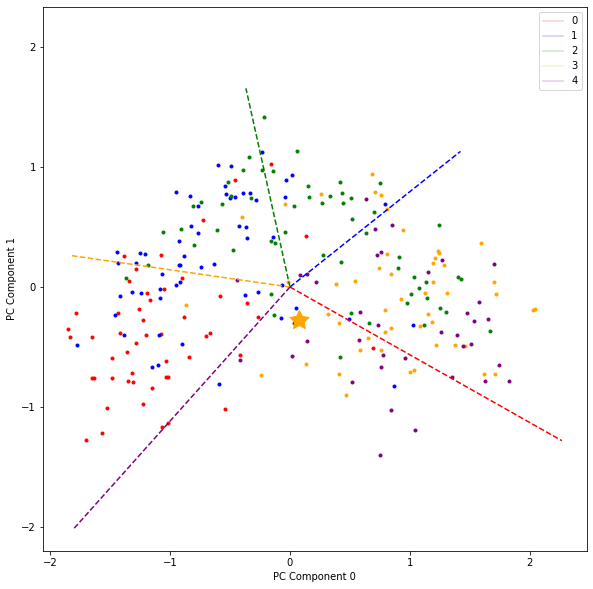

In [292]:
fig, ax = au.plot_states(final_by_value['transformed'], 
            readout_vectors['transformed'], 
            initial_state_vector['transformed'], 
            pc_dimensions=[0,1])
plt.axis('square')

In [143]:
plt.figure(figsize=(10,10))

def plot_traj(ang1, ang2):
    fig, ax = au.plot_states(final_by_value['transformed'], 
                readout_vectors['transformed'], 
                initial_state_vector['transformed'], 
                pc_dimensions=[0,1, 2])

    ax.view_init(ang1, ang2)    
    
interact(plot_traj, ang1=widgets.FloatSlider(value=0, min=0, max=180, step=3),
                    ang2=widgets.FloatSlider(value=0, min=0, max=180, step=3))

<Figure size 720x720 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='ang1', max=180.0, step=3.0), FloatSlider(value=0.0, …

<function __main__.plot_traj(ang1, ang2)>

### Accuracy when restricting to n dimensions

In [295]:
test_acc = measurements.AverageMeter()
n_dims = 2

for batch in tfds.as_numpy(test_dset):
    batch_final_states = au.rnn_end_states(cell, batch, rnn_params, emb_params, emb_apply)
    final_states_orig = np.vstack(batch_final_states)
    final_states_orig = au.squash(final_states_orig, PCA_objects['visited'], n_dims)
    logits = readout_apply(readout_params, final_states_orig)
    predictions = np.argmax(logits, axis=1)
    
    curr_acc = np.mean(predictions == batch['labels'])
    test_acc.update(curr_acc, len(batch['index']))

RuntimeError: Resource exhausted: Out of memory while trying to allocate 419430400 bytes.

In [296]:
test_acc.avg

0.5689947289156626

### Slowness 

In [157]:
transform_to_use = 'fixed'

In [158]:
x_lim = 3
y_lim = 3

density = 150 

x_range = np.linspace(-x_lim, x_lim, density)
y_range = np.linspace(-y_lim, y_lim, density)


In [169]:
dimension = PCA_objects[transform_to_use].n_components_
coordinates = {1: x_range, 
               2: y_range}
pca_plane = renn_au.pseudogrid(coordinates, dimension)
pca_transformed = PCA_objects[transform_to_use].inverse_transform(pca_plane)

In [170]:
fp_loss_fn = renn.build_fixed_point_loss(cell, rnn_params)

In [171]:
input_lin = jnp.zeros((pca_transformed.shape[0], config['model']['emb_size']))
fp_l = fp_loss_fn(pca_transformed, input_lin)

(-0.5, 149.5, 149.5, -0.5)

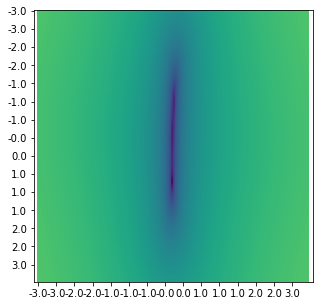

In [172]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(np.log10(fp_l).reshape(density, density), cmap='viridis', vmin=-5, vmax=2.5)
ax.set_xticks(range(len(x_range))[::10])
ax.set_xticklabels(np.round(x_range.T[::10]));
ax.set_yticks(range(len(y_range))[::10])
ax.set_yticklabels(np.round(y_range.T[::10]));
plt.axis('equal')

In [163]:
np.min(np.log10(fp_l))

-4.7590394

/usr/local/google/home/ramasesh/VirtualEnvs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


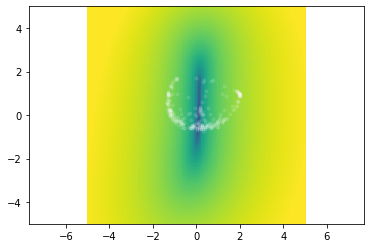

In [995]:
plt.pcolormesh(x_range, y_range, np.log10(fp_l).reshape(density, density), cmap='viridis', vmin=-6, vmax=+0.)
plt.axis('equal')
plt.scatter(fixed_points['transformed'][:,0], fixed_points['transformed'][:,1], color='white', marker='.', alpha=0.1)

In [996]:
max(np.log10(fp_l))

0.3133526

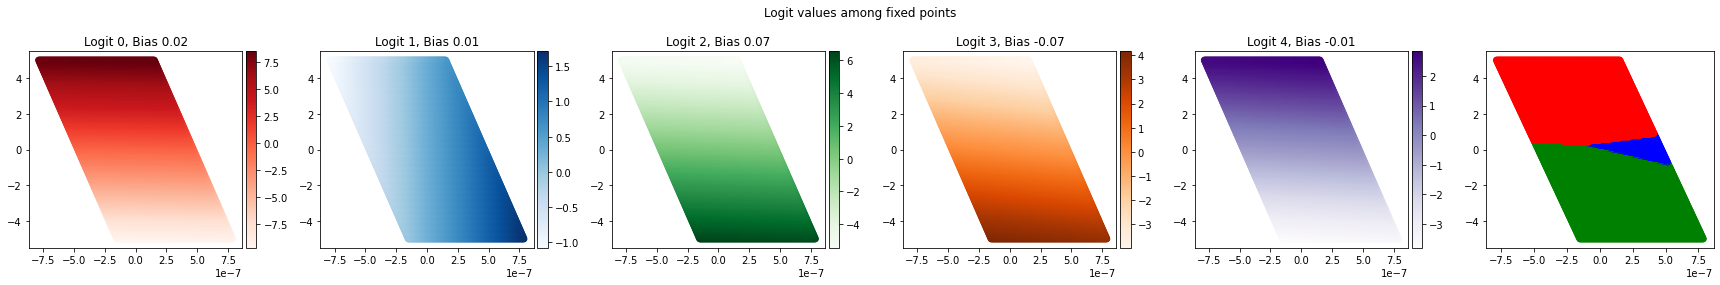

In [997]:
au.plot_logits(readout_apply, 
               readout_params, 
               pca_transformed, 
               PCA_objects[transform_to_use], 
               pc_dimensions=[0,1]);


### FIxed-point finding

In [144]:
transform_to_use='final'

In [151]:
fixed_points_, loss_hist, fp_losses = au.fixed_points(cell,
                                                    rnn_params,
                                                    final_states['original'],
                                                    tolerance=5e-6,
                                                    embedding_size=config['model']['emb_size'],
                                                    noise_scale=.4,
                                                    decimation_factor=1
                                                    )

fixed_points = {'original': fixed_points_,
                'transformed': PCA_objects[transform_to_use].transform(fixed_points_)}

Text(0, 0.5, 'Fixed point loss')

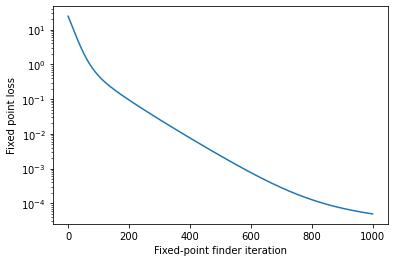

In [152]:
plt.semilogy(loss_hist)
plt.xlabel('Fixed-point finder iteration')
plt.ylabel('Fixed point loss')

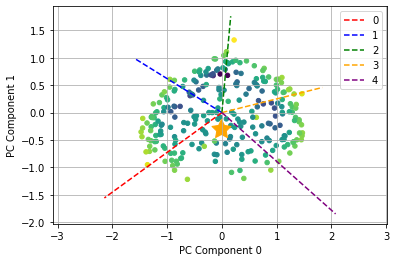

In [153]:
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1])
# plt.axis('equal');

(-10.0, 10.0)

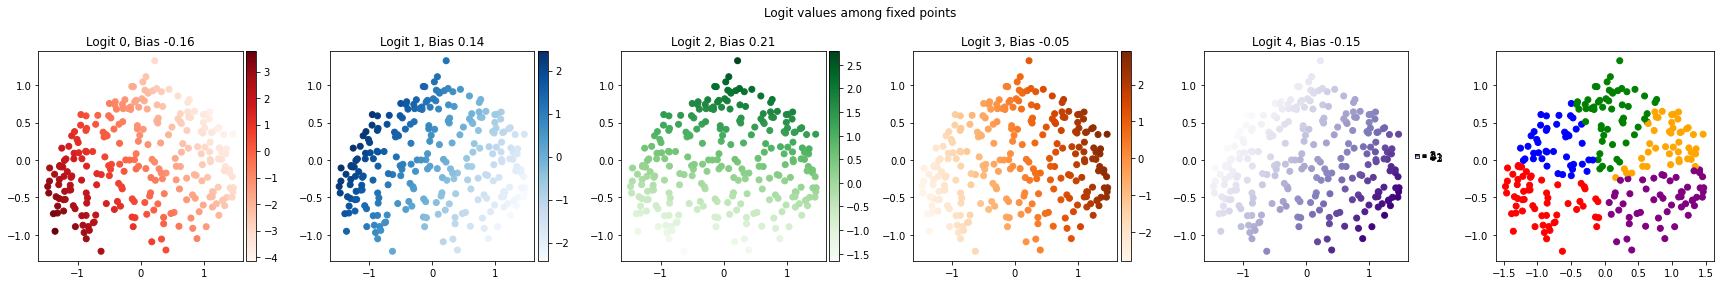

In [154]:
au.plot_logits(readout_apply, readout_params, fixed_points['original'], PCA_objects[transform_to_use], pc_dimensions=[0,1]);
plt.axis('equal')
plt.xlim(-10,10)

In [155]:
PCA_objects['fixed'].fit(fixed_points['original'])
dimensionalities['fixed']= au.cumulative_var_explained(PCA_objects['fixed'])

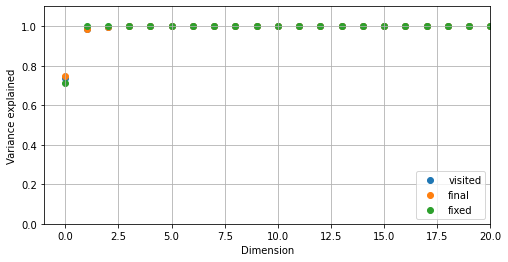

In [156]:
f = au.plot_varexp(dimensionalities)

### Visualizing some trajectories

In [229]:
visited_by_value['transformed'].keys()

dict_keys([0, 1, 2, 3, 4])

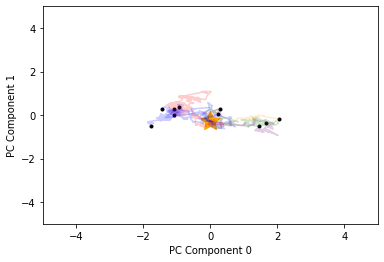

In [230]:
slice_to_plot = [10,20]
au.plot_traj_2d(visited_states['transformed'][slice_to_plot[0]:slice_to_plot[1]],
                pc_dimensions = [0,1],
                labels=test_batch['labels'][slice_to_plot[0]:slice_to_plot[1]],
                initial_state = initial_state_vector['transformed'],
                xlim=5, ylim=5)

In [231]:
xs = np.vstack(visited_states['transformed'])[:,0]
ys = np.vstack(visited_states['transformed'])[:,1]

(-2.2979021072387695,
 2.0722427368164062,
 -1.4041504859924316,
 1.5650131702423096)

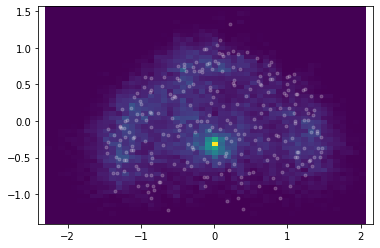

In [232]:
plt.hist2d(xs, ys,bins=50, density=True);
plt.scatter(fixed_points['transformed'][:,0], fixed_points['transformed'][:,1], color='white', marker='.', alpha=0.2)
plt.axis('equal')

### How many integrator eigenmodes?

In [173]:
fixed_point_index = 49

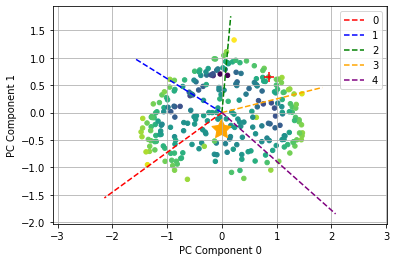

In [174]:
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1],
              point_to_highlight=fixed_point_index)

In [175]:
J_hh = cell.rec_jac(rnn_params, 
             jnp.zeros(config['model']['emb_size']), 
             fixed_points['original'][fixed_point_index])

R, E, L = renn.eigsorted(J_hh)

Text(0, 0.5, 'imag')

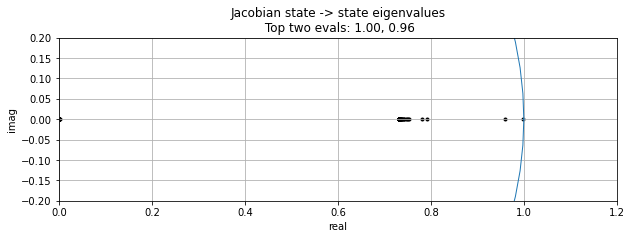

In [176]:
plt.figure(figsize=(10, 3))
plt.grid()
plt.scatter(np.real(E), np.imag(E), c='k', marker='.')


t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1)

plt.xlim(0.0, 1.2)
plt.ylim(-0.2, 0.2)

plt.title(f'Jacobian state -> state eigenvalues\n Top two evals: {np.real(E[0]):0.2f}, {np.real(E[1]):0.2f}')
plt.xlabel('real')
plt.ylabel('imag')
# plt.axis('equal')

Text(0, 0.5, 'imag')

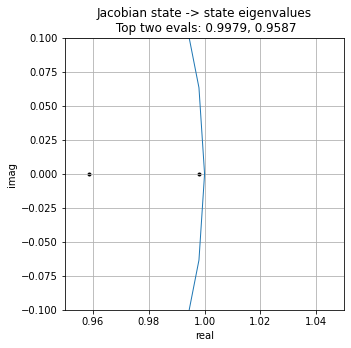

In [177]:
plt.figure(figsize=(5, 5))
plt.grid()
plt.scatter(np.real(E), np.imag(E), c='k', marker='.')
plt.xlim(0.95, 1.05)
plt.ylim(-0.1, 0.1)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1)

plt.title(f'Jacobian state -> state eigenvalues\n Top two evals: {np.real(E[0]):0.4f}, {np.real(E[1]):0.4f}')
plt.xlabel('real')
plt.ylabel('imag')

In [178]:
list(reversed(sorted(np.round(np.abs(1./np.log(np.abs(E)))))))[:10]

[475.0, 24.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0]

#### Time-constant across manifold

In [179]:
from importlib import reload
reload(au)

<module 'data_processing.analysis_utils' from '/usr/local/google/home/ramasesh/Projects/rnn_dynamics/data_processing/analysis_utils.py'>

In [180]:
top_time_constants = {0: [], 1: [], 2: [], 3: [], 4: []}
for fixed_point_index in range(len(fixed_points['original'])):
    J_hh = cell.rec_jac(rnn_params, 
             jnp.zeros(config['model']['emb_size']), 
             fixed_points['original'][fixed_point_index])

    R, E, L = renn.eigsorted(J_hh)
    
    time_constants = list(reversed(sorted(np.round(np.abs(1./np.log(np.abs(E)))))))
    for i in range(5):
        top_time_constants[i].append(time_constants[i])
    

[]

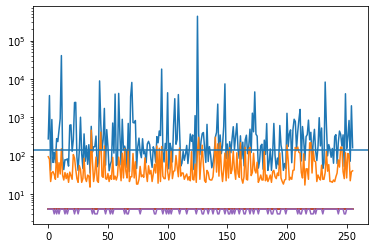

In [181]:
for i in range(5):
    plt.plot(top_time_constants[i])
plt.axhline(143)
plt.semilogy()

In [182]:
np.round([np.mean(top_time_constants[k]) for k in range(len(top_time_constants))])

array([2455.,   61.,    4.,    4.,    4.], dtype=float32)

Text(0, 0.5, 'Time constant')

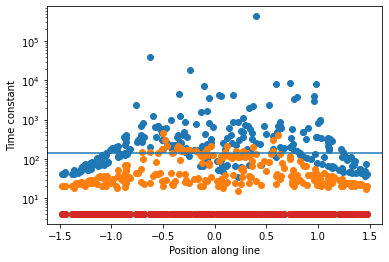

In [183]:
x = fixed_points['transformed'][:,0]
plt.scatter(x, top_time_constants[0])
plt.scatter(x, top_time_constants[1])
plt.scatter(x, top_time_constants[2])
plt.scatter(x, top_time_constants[3])
plt.semilogy()
plt.axhline(143)
plt.xlabel("Position along line")
plt.ylabel("Time constant")

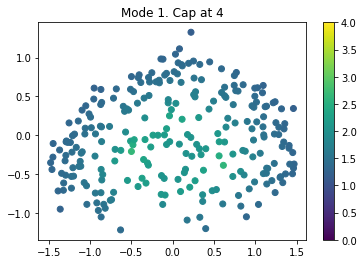

In [228]:
x = fixed_points['transformed'][:,0]
y = fixed_points['transformed'][:,1]

mode_to_see = 1
vmax=4

plt.scatter(x,y, c=np.log10(top_time_constants[mode_to_see]), vmin=0, vmax=vmax)
plt.title(f'Mode {mode_to_see}. Cap at {vmax}')
plt.colorbar()

#### Percent of top eigenmodes lying in the fixed-point plane

In [186]:
def in_plane_magnitudes(eigenvectors, PCA_obj, dimensions_to_keep=2):
    """
    eigenvectors is shape (n_points, evec_dimension, n_eigenvects)
    
    """
        
    mags = []
    
    for i in range(len(eigenvectors)):
        full_norms = np.linalg.norm(eigenvectors[i,:,:],axis=0)
        transformed = PCA_obj.transform_no_mean(np.real(eigenvectors[i,:,:].T))[:,:dimensions_to_keep]
        plane_norms = np.linalg.norm(transformed,axis=1)
        
        mags.append(plane_norms/full_norms)
    return np.array(mags)

In [244]:
n_integration_modes = 5
fixed_point_dim = 2

In [245]:
J_fn = lambda p : cell.rec_jac(rnn_params, jnp.zeros(config['model']['emb_size']), p)
top_evecs = au.top_evecs(J_fn, fixed_points['original'][::2], top_k = n_integration_modes)

In [262]:
evec_to_see = 1
top_evecs_kept = top_evecs[:,:,evec_to_see]

In [263]:
top_evecs_kept= top_evecs_kept[:,:,np.newaxis]

In [264]:
ipm = in_plane_magnitudes(top_evecs_kept, PCA_objects['fixed'], dimensions_to_keep=fixed_point_dim)

Text(0, 0.5, 'Frequency')

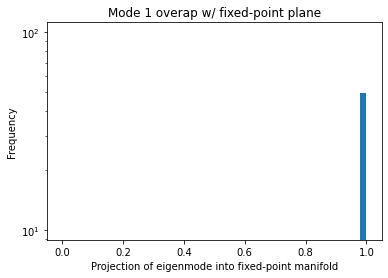

In [265]:
plt.title(f"Mode {evec_to_see} overap w/ fixed-point plane")
plt.hist(ipm.flatten(), bins=np.linspace(00.0,1,50), density=True, log=True);
plt.xlabel('Projection of eigenmode into fixed-point manifold')
plt.ylabel('Frequency')

### Effect of individual words

In [204]:
with open('./data/vocab/yelp.vocab', 'r') as f:
    vocab = f.readlines()

In [205]:
def get_deflections(word, vocab, initial_pts):
    
    word_index = vocab.index(f'{word}\n')
    word_input_ = emb_apply(emb_params, [word_index])
    word_input = jnp.repeat(word_input_, initial_pts.shape[0], axis=0)
    
    final_pts = cell.batch_apply(rnn_params, word_input, initial_pts)
    
    deflections = final_pts - initial_pts
    
    return deflections

In [218]:
initial_pts = fixed_points['original'][::5]
l = fp_losses

In [219]:
vocab.index('good\n')

109

In [241]:
test_words = ['excellent', 'great', 'okay', 'bad', 'horrible']

deflections = {}
transformed_deflections = {}
for test_word in test_words:
    deflections[test_word] = get_deflections(test_word, vocab, initial_pts)
    transformed_deflections[test_word] = PCA_objects['fixed'].transform_no_mean(deflections[test_word])

In [242]:
transformed_initial_pts = PCA_objects['fixed'].transform(initial_pts)

(-1.627286159992218, 1.681621515750885, -1.200073003768921, 2.108834671974182)

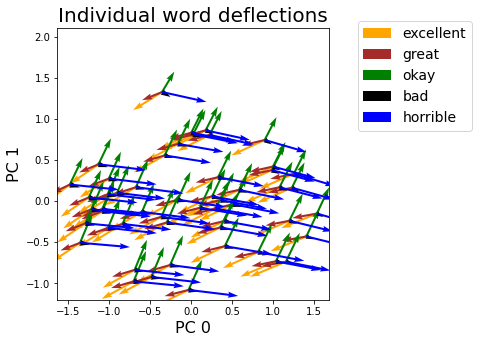

In [270]:
plt.figure(figsize=(5,5))

plt.scatter(transformed_initial_pts[:,0], transformed_initial_pts[:,1], 
            color='grey', alpha=0.8, marker='.')

COLORS = ['orange', 'brown', 'green', 'black', 'blue']
for ind, test_word in enumerate(test_words):
    plt.quiver(transformed_initial_pts[:,0], transformed_initial_pts[:,1],
               transformed_deflections[test_word][:,0], transformed_deflections[test_word][:,1], 
               scale=1, units='xy', color=COLORS[ind], label = test_word)

plt.legend(loc='upper right', fontsize=14,bbox_to_anchor=(1.55, 1.05))

plt.xlabel('PC 0', fontsize=16)
plt.ylabel('PC 1', fontsize=16)
plt.title('Individual word deflections', fontsize=20)
plt.axis('square')
# plt.ylim(-0.3, 0.3)

## Hunting for context

### Is there a context effect at all?

Before looking at changes to input Jacobians, we can first check whether a phrase like "not great" moves the hidden state in a different way than "great", or also "great not".  

In [1747]:
sequence = ['very ','good ']
inp_nums = [encoder.encode(s)[0] for s in sequence]

In [1748]:
inp_nums

[3075, 104]

In [1749]:
pts = initial_pts
for word in sequence:
    word_input_ = emb_apply(emb_params, encoder.encode(word))
    word_input = jnp.repeat(word_input_, initial_pts.shape[0], axis=0)
    pts = cell.batch_apply(rnn_params, word_input, pts)


In [1750]:
transformed_final = PCA_objects[transform_to_use].transform(pts).T

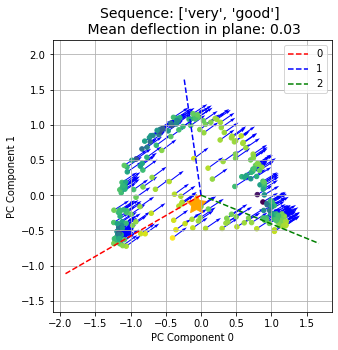

In [1751]:
initial_states = [transformed[0], transformed[1]]
final_states = np.array([transformed_final[0], transformed_final[1]])

deltas = final_states - np.array(initial_states)

plt.figure(figsize=(5,5))
plt.quiver(initial_states[0], initial_states[1], deltas[0], deltas[1], scale=1, units='xy', color='blue')
plt.axis('equal')

s = np.mean(deltas**2)

plt.title(f'Sequence: {sequence} \n Mean deflection in plane: {s:0.2f}', fontsize=14)
plt.xlabel('PC 0 component')
plt.ylabel('PC 1 component')

# plt.scatter(initial_states[0], initial_states[1], c = np.log10(l), marker='.')
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1])
plt.axis('equal');



#### All words at once

In [1752]:
words = ['extremely', 'good']

sequences = [[words[0]], [words[1]], words, words[::-1]]

finals_by_order = {}

for order in range(4):

    sequence = sequences[order]
    print(sequence)
    inp_nums = [encoder.encode(s)[0] for s in sequence]
    
    pts = initial_pts
    for word in sequence:
        word_input_ = emb_apply(emb_params, encoder.encode(word))
        word_input = jnp.repeat(word_input_, initial_pts.shape[0], axis=0)
        pts = cell.batch_apply(rnn_params, word_input, pts)

    finals_by_order[tuple(sequence)] = pts
    
    

['extremely']
['good']
['extremely', 'good']
['good', 'extremely']


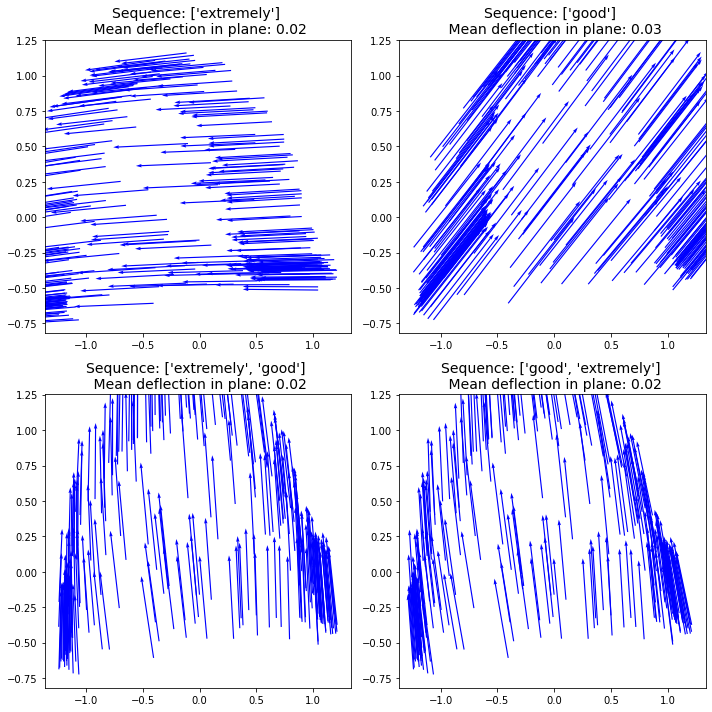

In [1753]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

for i in range(4):
    sequence = sequences[i]
    transformed_final = PCA_objects[transform_to_use].transform(finals_by_order[tuple(sequence)]).T
    
    initial_states = [transformed[0], transformed[1]]
    final_states = np.array([transformed_final[0], transformed_final[1]])

    deltas = final_states - np.array(initial_states)
    
    ax[i//2][i%2].quiver(initial_states[0], initial_states[1], deltas[0], deltas[1], scale=.3, units='xy', color='blue')

    s = np.mean(deltas**2)

    ax[i//2][i%2].set_title(f'Sequence: {sequence} \n Mean deflection in plane: {s:0.2f}', fontsize=14)

    plt.tight_layout()